In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole  # Jupyter上で分子構造表示可能にする
from rdkit.Chem import AllChem
import py3Dmol

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# SMILESの扱い

In [2]:
smiles_list = [
    "C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=CC=C3",  # トリフェニルアミン
    "C1=CC=C(C=C1)C2=CC=C(C=C2)N(C3=CC=C(C=C3)C4=CC=CC=C4)C5=CC=C(C=C5)C6=CC=CC=C6",
    "C1=CC=C(C=C1)N(C2=CC=CC=C2)C3=CC=C(C=C3)C4=CC=C(C=C4)N(C5=CC=CC=C5)C6=CC=CC=C6",
    "C1=CC=C2C(=C1)C=CC=C2C3=CC=C(C=C3)N(C4=CC=C(C=C4)C5=CC=CC6=CC=CC=C65)C7=CC=C(C=C7)C8=CC=CC9=CC=CC=C98"
]

In [3]:
# SMILESをカノニカル化（正規化）
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Chem.MolToSmiles(mol, canonical=True)
    else:
        return None

for i, smiles in enumerate(smiles_list):
    canonical_smiles = canonicalize_smiles(smiles)
    if canonical_smiles:
        smiles_list[i] = canonical_smiles
        
smiles_list

['c1ccc(N(c2ccccc2)c2ccccc2)cc1',
 'c1ccc(-c2ccc(N(c3ccc(-c4ccccc4)cc3)c3ccc(-c4ccccc4)cc3)cc2)cc1',
 'c1ccc(N(c2ccccc2)c2ccc(-c3ccc(N(c4ccccc4)c4ccccc4)cc3)cc2)cc1',
 'c1ccc2c(-c3ccc(N(c4ccc(-c5cccc6ccccc56)cc4)c4ccc(-c5cccc6ccccc56)cc4)cc3)cccc2c1']

# 分子の描画

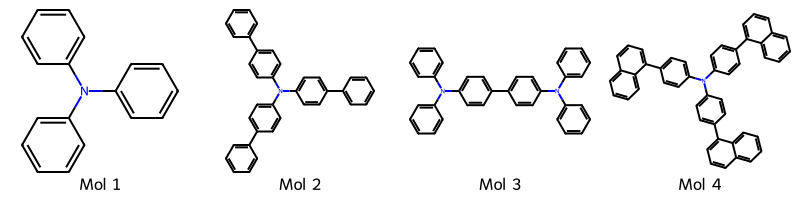

In [4]:
# --- SMILESからMolオブジェクトに変換 ---
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# --- 分子構造をJupyter上で可視化（2D） ---
Draw.MolsToImage(mols, subImgSize=(200, 200), legends=[f"Mol {i+1}" for i in range(len(mols))])

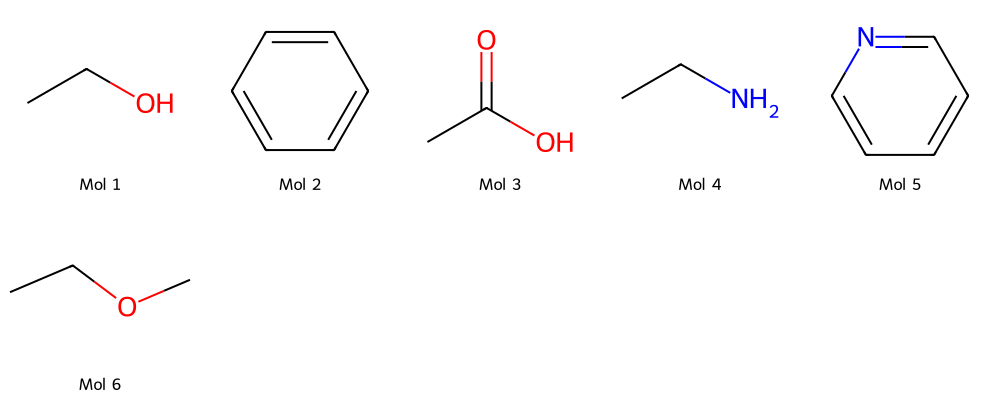

In [5]:
# --- サンプル: SMILESをMolに変換 ---
mols = [Chem.MolFromSmiles(s) for s in ["CCO", "c1ccccc1", "CC(=O)O", "CCN", "C1=CC=CN=C1", "CCOC"]]

# --- 2段に分けて表示 ---
Draw.MolsToGridImage(
    mols,
    molsPerRow=5,  # ← 1行あたり3分子（つまり2段×3列で6分子）
    subImgSize=(200, 200),
    legends=[f"Mol {i+1}" for i in range(len(mols))]
)

#img  # Jupyter上で画像として表示

In [6]:
mols

In [7]:
# Smilesの長さ
smiles_lengths = [len(smiles) for smiles in smiles_list]

# CとNのカウント
c_counts = [smiles.count('c') for smiles in smiles_list]
n_counts = [smiles.count('N') for smiles in smiles_list]

c_counts

[18, 36, 36, 48]

In [8]:
# 3次元構造の可視化
def show_3d(mol):
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    mb = Chem.MolToMolBlock(mol)
    
    viewer = py3Dmol.view(width=400, height=300)
    viewer.addModel(mb, "mol")
    viewer.setStyle({"stick": {}})
    viewer.setBackgroundColor("0xeeeeee")
    viewer.zoomTo()
    return viewer.show()

show_3d(mols[1])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# 分子の類似度（tanimoto係数）

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

from rdkit import DataStructs

In [10]:
# FPを生成する関数
def generate_fingerprints(smiles_list, fp_type):
    """
    fp_type : int
        フィンガープリント種別
        0: MACCS key
        1: RDKit
        2: Morgan
        3: Avalon
    """
    fp_list = []
    
    morgan_gen = None
    if fp_type == 2:
        morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)

    for smiles_i in smiles_list:
        mol = Chem.MolFromSmiles(smiles_i)
        if mol is None:
            fp_list.append(None)
            continue

        if fp_type == 0:
            fp_list.append(AllChem.GetMACCSKeysFingerprint(mol))
        elif fp_type == 1:
            fp_list.append(Chem.RDKFingerprint(mol))
        elif fp_type == 2:
            fp_list.append(morgan_gen.GetFingerprint(mol))
        elif fp_type == 3:
            fp_list.append(GetAvalonFP(mol))
        else:
            raise ValueError(f"Invalid fp_type: {fp_type}")
        
    fp_list = pd.DataFrame(np.array(fp_list, int))
    
    fp_names = []
    for i in range(len(fp_list.columns)):
        fp_names.append(f"FP_{i}")
    fp_list.columns = fp_names

    return fp_list

In [11]:
fps_0 = generate_fingerprints(smiles_list, 0)
fps_1 = generate_fingerprints(smiles_list, 1)
fps_2 = generate_fingerprints(smiles_list, 2)
fps_3 = generate_fingerprints(smiles_list, 3)


In [12]:
# FPを作成
maccs_fps = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mols]

rdkit_fps = [Chem.RDKFingerprint(mol) for mol in mols]

morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)
morgan_fps = [morgan_gen.GetFingerprint(mol) for mol in mols]

Avalon_fps = [GetAvalonFP(mol) for mol in mols]

In [13]:
rdkit_fps

In [14]:
# --- 分子間類似度（Tanimoto係数）を計算 ---
for i in range(len(rdkit_fps) - 1):
    for j in range(i + 1, len(rdkit_fps)):
        print(f"Tanimoto similarity between mol_{i} and mol_{j}:")
        print(f"{DataStructs.TanimotoSimilarity(rdkit_fps[i], rdkit_fps[j]):.3f}")

Tanimoto similarity between mol_0 and mol_1:
0.000
Tanimoto similarity between mol_0 and mol_2:
0.429
Tanimoto similarity between mol_0 and mol_3:
0.200
Tanimoto similarity between mol_0 and mol_4:
0.000
Tanimoto similarity between mol_0 and mol_5:
0.600
Tanimoto similarity between mol_1 and mol_2:
0.040
Tanimoto similarity between mol_1 and mol_3:
0.000
Tanimoto similarity between mol_1 and mol_4:
0.229
Tanimoto similarity between mol_1 and mol_5:
0.000
Tanimoto similarity between mol_2 and mol_3:
0.111
Tanimoto similarity between mol_2 and mol_4:
0.000
Tanimoto similarity between mol_2 and mol_5:
0.333
Tanimoto similarity between mol_3 and mol_4:
0.000
Tanimoto similarity between mol_3 and mol_5:
0.143
Tanimoto similarity between mol_4 and mol_5:
0.000


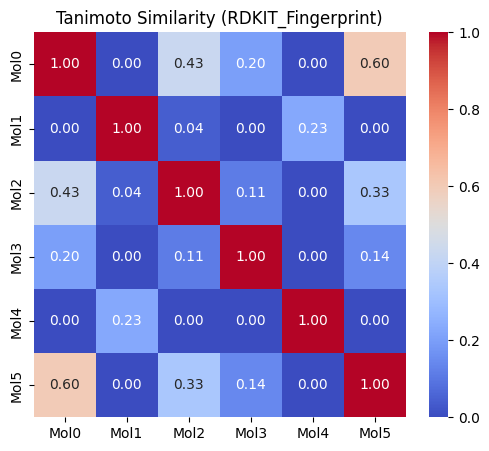

In [15]:
# ヒートマップを描画
def compute_similarity_matrix(fp_list):
    n = len(fp_list)
    sim_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
    return pd.DataFrame(sim_matrix, columns=[f"Mol{i}" for i in range(n)], index=[f"Mol{i}" for i in range(n)])

sim_rdkit = compute_similarity_matrix(rdkit_fps)

# ヒートマップで可視化
plt.figure(figsize=(6, 5))
sns.heatmap(sim_rdkit, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tanimoto Similarity (RDKIT_Fingerprint)")
plt.show()

In [16]:
for i in range(len(morgan_fps) - 1):
    for j in range(i + 1, len(morgan_fps)):
        print(f"Tanimoto similarity between mol_{i} and mol_{j}:")
        print(f"{DataStructs.TanimotoSimilarity(morgan_fps[i], morgan_fps[j]):.3f}")

Tanimoto similarity between mol_0 and mol_1:
0.000
Tanimoto similarity between mol_0 and mol_2:
0.182
Tanimoto similarity between mol_0 and mol_3:
0.333
Tanimoto similarity between mol_0 and mol_4:
0.000
Tanimoto similarity between mol_0 and mol_5:
0.273
Tanimoto similarity between mol_1 and mol_2:
0.111
Tanimoto similarity between mol_1 and mol_3:
0.000
Tanimoto similarity between mol_1 and mol_4:
0.333
Tanimoto similarity between mol_1 and mol_5:
0.000
Tanimoto similarity between mol_2 and mol_3:
0.083
Tanimoto similarity between mol_2 and mol_4:
0.067
Tanimoto similarity between mol_2 and mol_5:
0.071
Tanimoto similarity between mol_3 and mol_4:
0.000
Tanimoto similarity between mol_3 and mol_5:
0.273
Tanimoto similarity between mol_4 and mol_5:
0.000


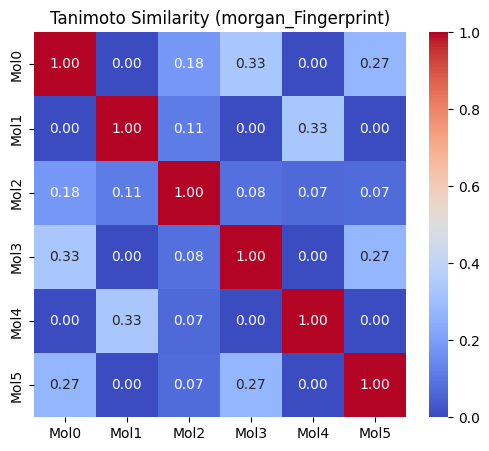

In [17]:
sim_morgan = compute_similarity_matrix(morgan_fps)

# ヒートマップで可視化
plt.figure(figsize=(6, 5))
sns.heatmap(sim_morgan, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tanimoto Similarity (morgan_Fingerprint)")
plt.show()

# 重水素化SMIELESの処理

ただの文字列変換

In [40]:
import re

def remove_deuterium_from_list(smiles_list):
    """
    SMILESリストから ([2H]) および [2H] を削除する
    （重水素を水素に変換する目的）
    """
    pattern = re.compile(r'\(\[2H\]\)|\[2H\]')
    cleaned_list = [pattern.sub('', smiles) for smiles in smiles_list]
    return cleaned_list


# --- 使用例 ---
smiles_list = [
    "C[2H]C([2H])C",
    "CC([2H])Br",
    "C1CC[2H]C1",
    "[2H]C(=O)O"
]

converted = remove_deuterium_from_list(smiles_list)
for original, new in zip(smiles_list, converted):
    print(original, "→", new)


C[2H]C([2H])C → CCC
CC([2H])Br → CCBr
C1CC[2H]C1 → C1CCC1
[2H]C(=O)O → C(=O)O


REKITの正規化あり

In [36]:
from rdkit import Chem
import re

def replace_deuterium_with_hydrogen(smiles_list):
    """
    SMILES中の重水素([2H])を通常の水素に変換する関数

    Parameters
    ----------
    smiles_list : list of str
        重水素を含む可能性のあるSMILESのリスト

    Returns
    -------
    list of str
        重水素を通常の水素に置換したSMILESリスト
    """
    new_smiles_list = []
    for smi in smiles_list:
        if smi is None:
            new_smiles_list.append(None)
            continue
        # [2H] → [H] に置換
        smi_replaced = re.sub(r'\[2H\]', '[H]', smi)
        # RDKitで正規化
        mol = Chem.MolFromSmiles(smi_replaced)
        if mol:
            smi_final = Chem.MolToSmiles(mol)
            new_smiles_list.append(smi_final)
        else:
            # 無効なSMILESの場合はNone
            new_smiles_list.append(None)
    return new_smiles_list


In [37]:
smiles_list = ["C([2H])O", "CC([2H])C", "C[2H]", "CCO"]
converted = replace_deuterium_with_hydrogen(smiles_list)
print(converted)


['CO', 'CCC', 'C', 'CCO']


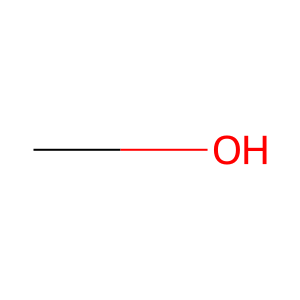

In [39]:
mols = Chem.MolFromSmiles("CO")

Draw.MolToImage(mols)

In [23]:
# !jupyter nbconvert --to html RDKIT_basic.ipynb